# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 11: Radiative Equilibrium and Radiative-Convective Equilibrium

### About these notes:

This document uses the interactive [`Jupyter notebook`](https://jupyter.org) format. The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2017 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2017/Notes/index.html).

[Also here is a legacy version from 2015](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

In [1]:
#  Ensure compatibility with Python 2 and 3
from __future__ import print_function, division

## Contents

1. [The observed annual, global mean temperature profile](#section1)
2. [Radiative equilibrium -- the concept](#section2)
3. [Pure radiative equilibrium in the RRTMG model](#section3)
4. [Effects of different gases on the radiative equilibrium profile](#section4)
5. [Summary of radiative equilibrium results](#section5)
6. [A radiative-convective model: adjustment toward equilibrium](#section6)
7. [Compare Radiative- and Radiative-Convective Equilibrium](#section7)
8. [The role of the critical lapse rate](#section8)

____________
<a id='section1'></a>

## 1. The observed annual, global mean temperature profile
____________

Let's look again the observations of air temperature from the NCEP Reanalysis data.

This just repeats what we did in the notebook `L06_Radiation.ipynb`. Refer back there for more details.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
from metpy.plots import SkewT
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation

In [3]:
# The NOAA ESRL server is shutdown! January 2019
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc",
                          decode_times=False)
#url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/NCEP/NCEP/clima/pressure/air'
#air = xr.open_dataset(url)
## The name of the vertical axis is different than the NOAA ESRL version..
#ncep_air = air.rename({'lev': 'level'})

In [4]:
#  Take global, annual average and convert to Kelvin
weight = np.cos(np.deg2rad(ncep_air.lat)) / np.cos(np.deg2rad(ncep_air.lat)).mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
print( Tglobal)

<xarray.DataArray (level: 17)>
array([ 15.179084,  11.207003,   7.838327,   0.219941,  -6.448343, -14.888848,
       -25.570469, -39.36969 , -46.797905, -53.652245, -60.56356 , -67.006065,
       -65.53293 , -61.48664 , -55.853584, -51.593952, -43.21999 ],
      dtype=float32)
Coordinates:
  * level    (level) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0


As we did before, we're going to plot these data on a "Skew-T" diagram. 

Here we'll make a function to create the diagram, because later we are going to reuse it several times.

In [5]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

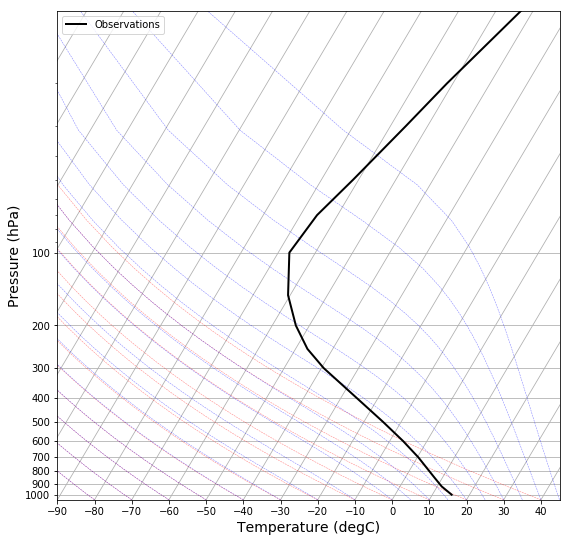

In [6]:
skew = make_skewT()

We are now going to work on some single-column models of the vertical temperature profile to understand physical factors determining the observed profile.

____________
<a id='section2'></a>

## 2. Radiative equilibrium -- the concept
____________

Models of radiative transfer slice up the atmospheric air column into a series of layer, and calculate the **emission** and **absorption** of radiation within each layer.

It's really just a generalization of the model we already looked at:

![Sketch of layer model](http://www.atmos.albany.edu/facstaff/brose/classes/ENV415_Spring2018/images/2layerAtm_sketch.png)

The concept of **radiative equilibrium** means that we **ignore all methods of heat exchange except for radiation**, and ask what temperature profile would exist under that assumption?

We can answer that question by using a radiative transfer model to explicity compute the shortwave and longwave beams, and the warming/cooling of each layer associated with the radiative sources and sinks of energy.

Basically, we reach radiative equilibrium when **energy is received and lost through radiation at the same rate in every layer**.

Because of the complicated dependence of emission/absorption features on the wavelength of radiation and the different gases, the beam is divided up into many different pieces representing different parts of the electromagnetic spectrum.

We will not look explicitly at this complexity here, but we will **use a model** that represents these processes at the same level of detail we would in a GCM.

____________
<a id='section3'></a>

## 3. Pure radiative equilibrium in the RRTMG model
____________

`climlab` provides two different "GCM-level" [radiation codes](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.Radiation.html):

- The [CAM3 radiation module](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.CAM3.html) from NCAR (essentially the same radiation code used in our CESM slab ocean simulations)
- The [RRTMG (Rapid Radiative Transfer Model)](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.RRTMG.html) which is used in many current GCMs.

The links above take you to the online [climlab documentation](http://climlab.readthedocs.io/en/latest/intro.html).

We're going to use a model called the [Rapid Radiative Transfer Model](http://rtweb.aer.com/rrtm_frame.html) or RRTMG. This is a "serious" and widely-used radiation model, used in many comprehensive GCMs and Numerical Weather Prediction models.

`climlab` provides an easy-to-use Python wrapper for the RRTMG code.

### Water vapor data

Before setting up the model, we need some water vapor data.

We're actually going to use the specific humidity field from our CESM control simulation:

In [7]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)

Take global, annual average of the specific humidity:

In [8]:
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))
Qglobal

<xarray.DataArray (lev: 26)>
array([2.162550e-06, 2.159117e-06, 2.149430e-06, 2.133799e-06, 2.119934e-06,
       2.111498e-06, 2.095464e-06, 2.118271e-06, 2.441435e-06, 3.155951e-06,
       5.057482e-06, 9.663076e-06, 2.100241e-05, 4.803590e-05, 1.056113e-04,
       2.117998e-04, 3.935585e-04, 7.106597e-04, 1.340892e-03, 2.050905e-03,
       3.162419e-03, 4.961048e-03, 6.608193e-03, 8.364253e-03, 9.364700e-03,
       9.629375e-03])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6

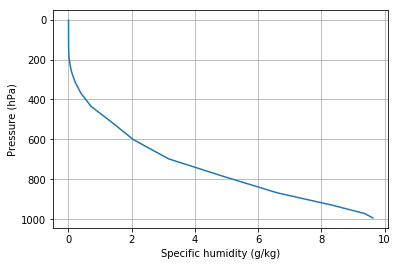

In [9]:
fig, ax = plt.subplots()
ax.plot(Qglobal*1000., Qglobal.lev)
ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)')
ax.grid()

### Create a single-column model on the same grid as this water vapor data:

In [10]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

In [11]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,
                             )
print(radmodel)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiation (all gases): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



Look at a few interesting properties of the model we just created:

In [12]:
#  Here's the state dictionary we already created:
radmodel.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

In [13]:
#  Here are the pressure levels in hPa
radmodel.lev

array([  3.544638 ,   7.3888135,  13.967214 ,  23.944625 ,  37.23029  ,
        53.114605 ,  70.05915  ,  85.439115 , 100.514695 , 118.250335 ,
       139.115395 , 163.66207  , 192.539935 , 226.513265 , 266.481155 ,
       313.501265 , 368.81798  , 433.895225 , 510.455255 , 600.5242   ,
       696.79629  , 787.70206  , 867.16076  , 929.648875 , 970.55483  ,
       992.5561   ])

There is a dictionary called `absorber_vmr` that holds the *volume mixing ratio* of all the radiatively active gases in the column"

In [14]:
radmodel.absorber_vmr

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([7.52507018e-06, 8.51545793e-06, 7.87041289e-06, 5.59601020e-06,
        3.46128454e-06, 2.02820936e-06, 1.13263102e-06, 7.30182697e-07,
        5.27326553e-07, 3.83940962e-07, 2.82227214e-07, 2.12188506e-07,
        1.62569291e-07, 1.17991442e-07, 8.23582543e-08, 6.25738219e-08,
        5.34457156e-08, 4.72688637e-08, 4.23614749e-08, 3.91392482e-08,
        3.56025264e-08, 3.12026770e-08, 2.73165152e-08, 2.47190016e-08,
        2.30518624e-08, 2.22005071e-08])}

Most are just a single number because they are assumed to be **well mixed** in the atmosphere.

The exception is ozone, which has a vertical structure taken from observations. Let's plot it

In [15]:
#  E.g. the CO2 content (a well-mixed gas) in parts per million
radmodel.absorber_vmr['CO2'] * 1E6

348.0

### Python exercise

Make a simple plot showing the vertical structure of ozone

In [16]:
# here is the data you need for the plot, as a plain numpy arrays:
print(radmodel.lev)
print(radmodel.absorber_vmr['O3'])

[  3.544638    7.3888135  13.967214   23.944625   37.23029    53.114605
  70.05915    85.439115  100.514695  118.250335  139.115395  163.66207
 192.539935  226.513265  266.481155  313.501265  368.81798   433.895225
 510.455255  600.5242    696.79629   787.70206   867.16076   929.648875
 970.55483   992.5561   ]
[7.52507018e-06 8.51545793e-06 7.87041289e-06 5.59601020e-06
 3.46128454e-06 2.02820936e-06 1.13263102e-06 7.30182697e-07
 5.27326553e-07 3.83940962e-07 2.82227214e-07 2.12188506e-07
 1.62569291e-07 1.17991442e-07 8.23582543e-08 6.25738219e-08
 5.34457156e-08 4.72688637e-08 4.23614749e-08 3.91392482e-08
 3.56025264e-08 3.12026770e-08 2.73165152e-08 2.47190016e-08
 2.30518624e-08 2.22005071e-08]


The other radiatively important gas is of course water vapor, which is stored separately in the `specific_humidity` attribute:

In [17]:
#  specific humidity in kg/kg, on the same pressure axis
radmodel.specific_humidity

array([2.16255006e-06, 2.15911701e-06, 2.14943023e-06, 2.13379934e-06,
       2.11993381e-06, 2.11149790e-06, 2.09546420e-06, 2.11827126e-06,
       2.44143531e-06, 3.15595114e-06, 5.05748229e-06, 9.66307595e-06,
       2.10024053e-05, 4.80359029e-05, 1.05611312e-04, 2.11799800e-04,
       3.93558531e-04, 7.10659654e-04, 1.34089154e-03, 2.05090474e-03,
       3.16241947e-03, 4.96104823e-03, 6.60819328e-03, 8.36425275e-03,
       9.36470014e-03, 9.62937462e-03])

### The RRTMG radiation model has lots of different input parameters

For details you can look at the [documentation](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.radiation.html)

In [18]:
for item in radmodel.input:
    print(item)

specific_humidity
absorber_vmr
cldfrac
clwp
ciwp
r_liq
r_ice
emissivity
S0
insolation
coszen
eccentricity_factor
aldif
aldir
asdif
asdir
icld
irng
idrv
permuteseed_sw
permuteseed_lw
dyofyr
inflgsw
inflglw
iceflgsw
iceflglw
liqflgsw
liqflglw
tauc_sw
tauc_lw
ssac_sw
asmc_sw
fsfc_sw
tauaer_sw
ssaaer_sw
asmaer_sw
ecaer_sw
tauaer_lw
isolvar
indsolvar
bndsolvar
solcycfrac


Many of the parameters control the radiative effects of clouds.

But here we should note that the model is initialized with no clouds at all:

In [19]:
radmodel.cldfrac

0.0

### Step the model forward in time!

Here are the current temperatures (initial condition):

In [20]:
radmodel.Ts

Field([288.])

In [21]:
radmodel.Tatm

Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])

Now let's take a single timestep:

In [22]:
radmodel.step_forward()

In [23]:
radmodel.Ts

Field([288.5764762])

The surface got warmer! 

Let's take a look at all the diagnostic information that was generated during that timestep:

Every `climlab` model has a `diagnostics` dictionary. Here we are going to check it out as an `xarray` dataset:

In [24]:
climlab.to_xarray(radmodel.diagnostics)

<xarray.Dataset>
Dimensions:           (depth: 1, depth_bounds: 2, lev: 26, lev_bounds: 27)
Coordinates:
  * depth             (depth) float64 1.25
  * depth_bounds      (depth_bounds) float64 0.0 2.5
  * lev               (lev) float64 3.545 7.389 13.97 ... 929.6 970.6 992.6
  * lev_bounds        (lev_bounds) float64 0.0 5.467 10.68 ... 950.1 981.6 1e+03
Data variables:
    OLR               (depth) float64 251.0
    OLRclr            (depth) float64 251.0
    OLRcld            (depth) float64 0.0
    TdotLW            (lev) float64 -1.505 -0.8463 -0.8032 ... -0.1968 1.523
    TdotLW_clr        (lev) float64 -1.505 -0.8463 -0.8032 ... -0.1968 1.523
    LW_sfc            (depth) float64 94.05
    LW_sfc_clr        (depth) float64 94.05
    LW_flux_up        (lev_bounds) float64 251.0 251.3 251.7 ... 360.4 390.1
    LW_flux_down      (lev_bounds) float64 0.0 1.214 2.106 ... 254.6 269.7 296.0
    LW_flux_net       (lev_bounds) float64 251.0 250.1 249.5 ... 90.72 94.05
    LW_flux_up_clr 

The main "job" of a radiative transfer model it to calculate the shortwave and longwave fluxes up and down between each model layer.

For example:

In [25]:
climlab.to_xarray(radmodel.LW_flux_up)

<xarray.DataArray (lev_bounds: 27)>
array([251.047159, 251.285711, 251.654273, 252.393846, 253.530432, 254.974513,
       256.54334 , 257.984705, 259.266985, 260.588415, 262.004427, 263.549501,
       265.279088, 267.265231, 269.657799, 272.60065 , 276.201332, 280.493681,
       285.597399, 291.930843, 299.424326, 308.286012, 319.22169 , 331.845081,
       346.026836, 360.387137, 390.099018])
Coordinates:
  * lev_bounds  (lev_bounds) float64 0.0 5.467 10.68 18.96 ... 950.1 981.6 1e+03

These are upward longwave fluxes in W/m2.

Why are there 27 data points, when the model has 26 pressure levels?

In [26]:
radmodel.lev

array([  3.544638 ,   7.3888135,  13.967214 ,  23.944625 ,  37.23029  ,
        53.114605 ,  70.05915  ,  85.439115 , 100.514695 , 118.250335 ,
       139.115395 , 163.66207  , 192.539935 , 226.513265 , 266.481155 ,
       313.501265 , 368.81798  , 433.895225 , 510.455255 , 600.5242   ,
       696.79629  , 787.70206  , 867.16076  , 929.648875 , 970.55483  ,
       992.5561   ])

In [27]:
radmodel.lev_bounds

array([   0.        ,    5.46672575,   10.67801375,   18.9559195 ,
         30.5874575 ,   45.1724475 ,   61.5868775 ,   77.7491325 ,
         92.976905  ,  109.382515  ,  128.682865  ,  151.3887325 ,
        178.1010025 ,  209.5266    ,  246.49721   ,  289.99121   ,
        341.1596225 ,  401.3566025 ,  472.17524   ,  555.4897275 ,
        648.660245  ,  742.249175  ,  827.43141   ,  898.4048175 ,
        950.1018525 ,  981.555465  , 1000.        ])

The last element of the flux array represents the **upward flux from the surface to the first level**:

In [28]:
radmodel.LW_flux_up[-1]

390.09901849147116

The value is about 390 W m$^{-2}$. 

Why?

In [29]:
sigma = 5.67E-8
sigma * 288**4

390.0793946112

The surface temperature was initialized at 288 K, and the surface is treated as very close to a blackbody in the model.

What about the flux from the top layer out to space?

Two ways to access this information:

In [30]:
radmodel.LW_flux_up[0]

251.04715901472403

In [31]:
radmodel.OLR

Field([251.04715901])

Of course there is a whole other set of fluxes for the shortwave radiation.

One diagnostic we will often want to look at is the **net energy budget at the top of the atmosphere**:

In [32]:
radmodel.ASR - radmodel.OLR

Field([3.72695577])

Is the model gaining or losing energy?

### Integrate out to equilibrium

In [33]:
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    radmodel.step_forward()

Check the energy budget again:

In [34]:
#  Check the energy budget again
radmodel.ASR - radmodel.OLR

Field([0.00990126])

### Compare the radiative equilibrium temperature to observations

Here's a helper function we'll use to add model temperature profiles to our skew-T plot:

In [35]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

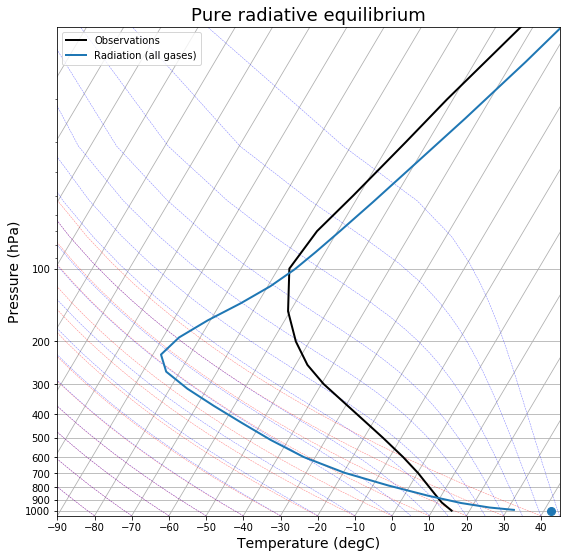

In [36]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

What do you think about this model -- data comparison?

____________
<a id='section4'></a>

## 4. Effects of different gases on the radiative equilibrium profile
____________

Models are for experimenting and playing with!

We have just built a single-column radiation model with several different absorbing gases. We can learn about their effects by taking them away.

In [37]:
# Make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
radmodel_noH2O.name = 'Radiation (no H2O)'
print(radmodel_noH2O)

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiation (no H2O): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



In [38]:
#  Here is the water vapor profile we started with
radmodel_noH2O.specific_humidity

array([2.16255006e-06, 2.15911701e-06, 2.14943023e-06, 2.13379934e-06,
       2.11993381e-06, 2.11149790e-06, 2.09546420e-06, 2.11827126e-06,
       2.44143531e-06, 3.15595114e-06, 5.05748229e-06, 9.66307595e-06,
       2.10024053e-05, 4.80359029e-05, 1.05611312e-04, 2.11799800e-04,
       3.93558531e-04, 7.10659654e-04, 1.34089154e-03, 2.05090474e-03,
       3.16241947e-03, 4.96104823e-03, 6.60819328e-03, 8.36425275e-03,
       9.36470014e-03, 9.62937462e-03])

Now get rid of the water entirely!

In [39]:
radmodel_noH2O.specific_humidity *= 0.

In [40]:
radmodel_noH2O.specific_humidity

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

In [42]:
radmodel_noH2O.ASR - radmodel_noH2O.OLR

Field([-0.00998947])

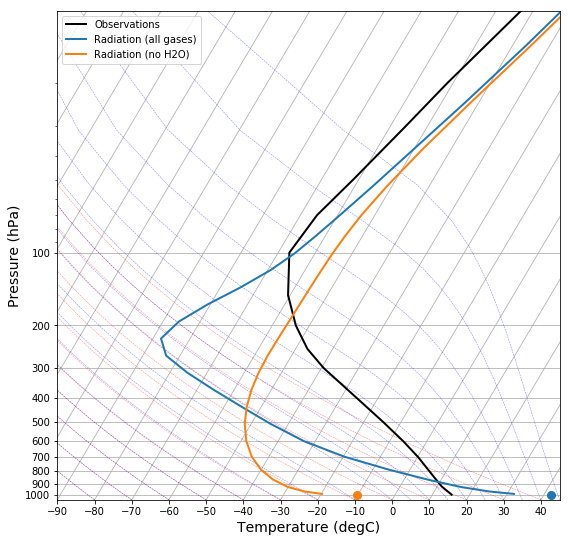

In [43]:
skew = make_skewT()
for model in [radmodel, radmodel_noH2O]:
    add_profile(skew, model)

What do you think you can learn from this about the radiative role of water vapor?

### Exercise

Following the steps above, make another model, but this time instead of removing the water vapor, remove the ozone!

Make another skew-T plot comparing all three model results.

____________
<a id='section5'></a>

## 5. Summary of radiative equilibrium results
____________

- We used the `RRTMG` radiation model with prescribed profiles of absorbing gases to calculate **pure radiative equilibrium** temperature profiles.
- Radiative Equilibriu means the temperatures that the surface and air column would have **if radiation was the only physical process that could transfer energy between levels**.
- We computed several different radiative equilibrium profiles, with and without key absorbing gases
    - The profile without water vapor is **much colder at surface and lower troposphere**, but about the same in the stratosphere
    - The profile without ozone is **much colder in the stratosphere**, but about the same near the surface.
    - In fact there really isn't a stratosphere at all without ozone! The temperature is nearly isothermal in the upper atmosphere in that profile.

However the really key takeaway message is that **none of these radiative equilibrium profiles look much like the observations in the troposphere**.

This strongly suggests that other physical processes (aside from radiation) are important in determining the observed temperature profile.

Plotting on the skew-T diagram makes it clear that **all the radiative equilibrium profiles are statically unstable near the surface**.

The next step is therefore to look at the effects of convective mixing on the temperatures of the surface and lower troposphere.

____________
<a id='section6'></a>

## 6. A radiative-convective model: adjustment toward equilibrium
____________


To make a **Radiative-Convective model**, we just take a **radiation** model and couple it to a **convection** model!

The "convection" model we're going to use here is available as

```
climlab.convection.ConvectiveAdjustment
```

It is a simple process that looks for **lapse rates exceeding a critical threshold** and performs an **instantaneous adjustment** that mixes temperatures to the critical lapse rate while conserving energy.

This is a **parameterization** of the complex, rapid mixing processes that actually occur in an unstable air column!

Here is some code to put this model together in `climlab`:

In [44]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
rad = climlab.radiation.RRTMG(name='Radiation (net)',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=state,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,)
rcm = climlab.couple([rad, conv], name='Radiative-Convective Model')

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [45]:
print(rcm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiative-Convective Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation (net): <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



To get some insight into the interaction between radiation and convection, it's useful to look at the adjustment process from a non-equilibrium initial condition.

**Let's make an animation!**

The code below is complicated but it is mostly for generating the animation. Focus on the results, not the code here.

In [46]:
def get_tendencies(model):
    '''Pack all the subprocess tendencies into xarray.Datasets
    and convert to units of K / day'''
    tendencies_atm = xr.Dataset()
    tendencies_sfc = xr.Dataset()
    for name, proc, top_proc in climlab.utils.walk.walk_processes(model, topname='Total', topdown=False):
        tendencies_atm[name] = proc.tendencies['Tatm'].to_xarray()
        tendencies_sfc[name] = proc.tendencies['Ts'].to_xarray()
    for tend in [tendencies_atm, tendencies_sfc]:
        #  convert to K / day
        tend *= climlab.constants.seconds_per_day
    return tendencies_atm, tendencies_sfc

def initial_figure(model):
    fig = plt.figure(figsize=(14,6))
    lines = []
    
    skew = SkewT(fig, subplot=(1,2,1), rotation=30)
    #  plot the observations
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')    
    lines.append(skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK, 
              linestyle='-', linewidth=2, color='C0', label='RC model (all gases)')[0])
    skew.ax.legend()
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-60, 75)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    skew.ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    lines.append(skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
                  markersize=8, color='C0', )[0])

    ax = fig.add_subplot(1,2,2, sharey=skew.ax)
    ax.set_ylim(1050, 10)
    ax.set_xlim(-8,8)
    ax.grid()
    ax.set_xlabel('Temperature tendency ($^\circ$C day$^{-1}$)', fontsize=14)

    color_cycle=['g','b','r','y','k']
    #color_cycle=['y', 'r', 'b', 'g', 'k']
    tendencies_atm, tendencies_sfc = get_tendencies(rcm)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines.append(ax.plot(tendencies_atm[name], model.lev, label=name, color=color_cycle[i])[0])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines.append(ax.plot(tendencies_sfc[name], 1000, 'o', markersize=8, color=color_cycle[i])[0])
    ax.legend(loc='center right');
    lines.append(skew.ax.text(-100, 50, 'Day {}'.format(int(model.time['days_elapsed'])), fontsize=12)) 
    return fig, lines

def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm)-climlab.constants.tempCtoK)
    lines[1].set_xdata(np.array(model.Ts)-climlab.constants.tempCtoK)
    #lines[2].set_xdata(np.array(model.q)*1E3)
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines[2+i].set_xdata(tendencies_atm[name])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines[2+5+i].set_xdata(tendencies_sfc[name])
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines

We are going to start from an **isothermal** initial state, and let the model drift toward equilibrium.

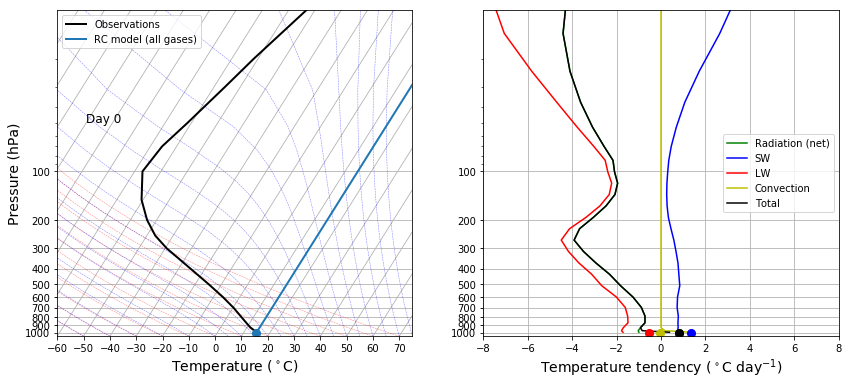

In [47]:
#  Start from isothermal state
rcm.state.Tatm[:] = rcm.state.Ts
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm)

Notice several things here:

- The initial profile is isothermal at 15ºC. This is an arbitrary choice we made.
- The initial tendency from **convection** is zero everywhere. Why?
- Shortwave radiation tends to **warm everywhere**. Why?
- Longwave radiation tends to **cool everywhere**. The cooling is very strong especially aloft. Why?
- The total tendency (black) is warming at the surface and cooling in the atmosphere. What should happen next? What are the implications for convective instability?

Now let's look at how the model actually adjusts:

In [48]:
#  This is where we make a loop over many timesteps and create an animation in the notebook
ani = animation.FuncAnimation(fig, animate, 150, fargs=(rcm, lines))
HTML(ani.to_html5_video())

Discuss.

### What if instead we start out from pure Radiative equilibrium?

This will represent the effect of a sudden "switching on" of convective processes.

In [49]:
#  Here we take JUST THE RADIATION COMPONENT of the full model and run it out to (near) equilibrium
#  This is just to get the initial condition for our animation
for n in range(1000):
    rcm.subprocess['Radiation (net)'].step_forward()

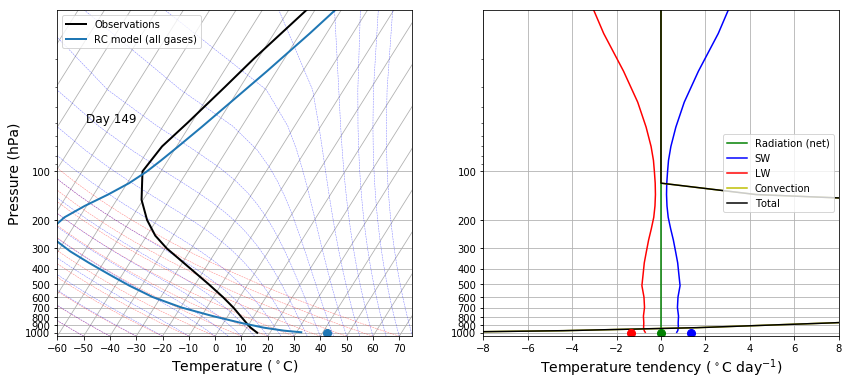

In [50]:
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(rcm)

In [51]:
#  This is where we make a loop over many timesteps and create an animation in the notebook
ani = animation.FuncAnimation(fig, animate, 100, fargs=(rcm, lines))
HTML(ani.to_html5_video())

This animation is not as exciting because the **instability is destroyed immediately** in the first timestep!

That is because the `ConvectiveAdjustment` process operates instantaneously whenever there is any instability. It is a parameterization taking advantage of the fact that, in nature, **convection processes are fast compared to radiative processes**.

But notice that the final state is pretty much the same as in the first animation.

**The column tends toward the same equilibrium state regardless of where it starts.**

____________
<a id='section7'></a>

## 7. Compare Radiative- and Radiative-Convective Equilibrium
____________

Let's repeat our experiment with removing certain absorbing gases from the model, but use the Radiative-Convective model.

In [52]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

rad = climlab.radiation.RRTMG(name='all gases',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )
#  remove ozone
rad_noO3 = climlab.process_like(rad)
rad_noO3.absorber_vmr['O3'] *= 0.
rad_noO3.name = 'no O3'
#  remove water vapor
rad_noH2O = climlab.process_like(rad)
rad_noH2O.specific_humidity *= 0.
rad_noH2O.name = 'no H2O'
#  remove both
rad_noO3_noH2O = climlab.process_like(rad_noO3)
rad_noO3_noH2O.specific_humidity *= 0.
rad_noO3_noH2O.name = 'no O3, no H2O'
#  put all models together in a list
rad_models = [rad, rad_noO3, rad_noH2O, rad_noO3_noH2O]

rc_models = []
for r in rad_models:
    newrad = climlab.process_like(r)
    conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=newrad.state,
                                               adj_lapse_rate=6.5,
                                               timestep=newrad.timestep,)
    rc = newrad + conv
    rc.name = newrad.name
    rc_models.append(rc)

for model in rad_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()    
    
for model in rc_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


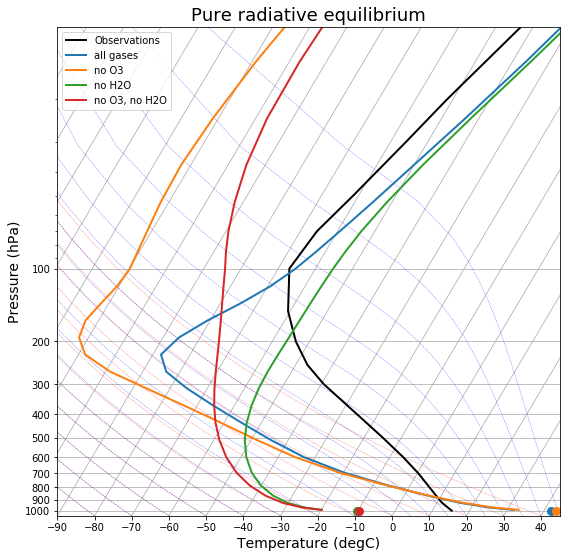

In [53]:
skew = make_skewT()
for model in rad_models:
    add_profile(skew, model)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

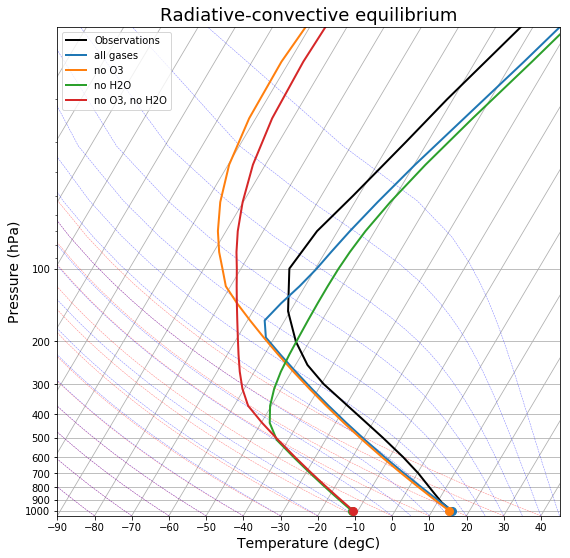

In [54]:
skew2 = make_skewT()
for model in rc_models:
    add_profile(skew2, model)
skew2.ax.set_title('Radiative-convective equilibrium', fontsize=18);

Lots to discuss here.

The overall message is that equilibrium temperature profile results from a competition between radiation and convection. Essentially:

- Radiation is always trying to push temperatures toward radiative equilibrium, which means
    - warm surface
    - cold troposphere
- Convection cools the surface and warms the troposphere
- The troposphere can be defined here as the layer over which convection is active.
- This is true whether or not we have the radiative effects of water vapor.
- When we remove the water vapor (and its warming greenhouse effect), the surface temperature becomes much colder and the troposphere is much shallower -- but it is still there.

____________
<a id='section8'></a>

## 8. The role of the critical lapse rate
____________

These calculations all used a critical lapse rate of 6.5 K / km, which is a reasonable approximation to observations.

We set this with the input argument
```
adj_lapse_rate
```
to the `ConvectiveAdjustment` process.

The idea is that we are trying to represent the statistical effects of many episodes of moist convection.

An air column that is perfectly neutral to moist instability would follow the blue **moist adiabats** on the skew-T diagrams.

We can force the model to behave this way by setting
```
adj_lapse_rate = 'pseudoadiabat'
```

However the real atmosphere, on average, does not exactly follow these adiabats for several reasons:

- the slope of the moist adiabat depends strongly on temperature (as we can see on these diagrams)
- We are looking at temperatures averaged over the whole planet, including regions that are warm and moist, warm and dry, and cold.
- Heat fluxes by mid-latitude eddies play an important role in **stabilizing** the extra-tropical atmosphere.

So here we sweep all this complexity under the rug and just choose a single critical lapse rate for our convective adjustment model.

But this is a **parameter** that is uncertain and could be interesting to explore.

### Python exercise

Repeat the whole series of calculations for the different combinations of absorbing gases above, but with different critical lapse rates:

- `adj_lapse_rate = 9.8` (in K/km, the dry adiabatic lapse rate, suitable for an atmosphere where condensation does not impact the buoyancy of air parcels)
- `adj_lapse_rate = 'pseudoadiabat'` (more suitable for the tropical atmosphere)

____________
## Version information
____________


In [55]:
%load_ext version_information
%version_information numpy, matplotlib, climlab

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.14.3
matplotlib 2.2.2
climlab 0.7.1
Tue Feb 19 12:14:30 2019 EST

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________